# **Ejemplo Red Neuronal Profunda**

Se explicará detalladamente como entrenar una red neuronal profunda en el conjunto de datos MNIST.

Partiremos describiendo las bibliotecas que se instalan (`torch`, `torchvision`, `tqdm`) y para qué se utilizan en el código.

In [1]:
!pip install -q torch torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.5 MB/s eta 0:00:00


El código instala e importa las siguientes bibliotecas:

1.  **torch**: Una biblioteca de código abierto para aprendizaje automático. Se utiliza para construir y entrenar la red neuronal (DeepMLP), realizar operaciones tensoriales, calcular gradientes (autograd) y optimizar el modelo.

2.  **torchvision**: Una biblioteca que forma parte del ecosistema PyTorch. Contiene conjuntos de datos populares (como MNIST), arquitecturas de modelos y transformaciones de imagen. En este código, se utiliza para descargar y cargar el conjunto de datos MNIST y aplicar transformaciones a las imágenes.

3.  **tqdm**: Una biblioteca que proporciona barras de progreso rápidas y extensibles para bucles. Aunque se importa, no se utiliza explícitamente en la función `train_model` proporcionada para mostrar el progreso de los bucles de entrenamiento o validación.

En resumen, estas bibliotecas son fundamentales para definir, cargar los datos, entrenar y evaluar el modelo de red neuronal profunda.

In [2]:
import torch, torch.nn as nn, torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

A continuación, se detalla cómo se cargan y preparan los conjuntos de datos MNIST para el entrenamiento:

1.  **Carga de los conjuntos de datos MNIST**: Se utiliza `torchvision.datasets.MNIST` para cargar los datos.
    *   `root="data"`: Especifica el directorio donde se descargarán o se buscarán los datos de MNIST.
    *   `train=True`: Indica que se cargará el conjunto de entrenamiento (60,000 imágenes y etiquetas).
    *   `train=False`: Indica que se cargará el conjunto de validación (10,000 imágenes y etiquetas).
    *   `download=True`: Si el conjunto de datos no se encuentra en el directorio especificado por `root`, se descarga automáticamente.
    *   `transform=tfms`: Aplica las transformaciones definidas en el objeto `tfms` a cada imagen cargada.

2.  **Transformaciones aplicadas a los datos**:
    *   `tfms = transforms.Compose([...])`: `Compose` encadena múltiples transformaciones para aplicarlas en secuencia.
    *   `transforms.ToTensor()`: Convierte las imágenes PIL (Python Imaging Library) o NumPy ndarrays en tensores PyTorch. Además, escala los valores de píxel de [0, 255] a [0.0, 1.0]. Esto es necesario porque PyTorch trabaja con tensores.
    *   `transforms.Normalize((0.1307,), (0.3081,))`: Normaliza el tensor de imagen. Para cada canal, esta transformación calcula `(imagen[canal] - media[canal]) / desviacion_estandar[canal])`. Los valores (0.1307) y (0.3081) son la media y la desviación estándar del conjunto de datos MNIST, calculados previamente. La normalización ayuda a que la red neuronal converja más rápido y a menudo mejora el rendimiento.

3.  **Creación de los DataLoaders**:
    *   `torch.utils.data.DataLoader`: Es un iterador que envuelve un conjunto de datos (`Dataset`) y proporciona iteraciones por lotes de datos. Esto es crucial para el entrenamiento de redes neuronales, ya que se entrena en mini-lotes en lugar de procesar todo el conjunto de datos a la vez.
    *   `dataset`: El conjunto de datos a cargar (por ejemplo, `train_ds` o `val_ds`).
    *   `batch_size`: Define el número de muestras por lote a cargar. Para el entrenamiento (`train_dl`), se usa un tamaño de lote de 128. Para la validación (`val_dl`), se usa un tamaño de lote de 256. Un tamaño de lote más grande para la validación puede ser más eficiente ya que no se calculan gradientes.
    *   `shuffle=True`: Para el `train_dl`, se baraja el conjunto de datos en cada época. Esto ayuda a evitar que el modelo aprenda el orden de las muestras y mejora la generalización. Para `val_dl`, `shuffle` se omite por defecto (que es False), ya que el orden de los datos no importa durante la validación.

In [3]:
# Datos
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_ds = datasets.MNIST(root="data", train=True,  download=True, transform=tfms)
val_ds   = datasets.MNIST(root="data", train=False, download=True, transform=tfms)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl   = torch.utils.data.DataLoader(val_ds,   batch_size=256)


100%|██████████| 9.91M/9.91M [00:00<00:00, 91.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 39.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 62.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.39MB/s]


La clase `DeepMLP` define una red neuronal profunda configurable. Su arquitectura se construye de la siguiente manera:

1.  **Propósito**: `DeepMLP` es un modelo de red neuronal multicapa perceptrón (MLP) diseñado para ser flexible. Permite definir el número y tamaño de las capas ocultas, la probabilidad de dropout y la función de activación.

2.  **Construcción de Capas (`__init__`)**:
    *   El constructor `__init__` inicializa la red. Toma una lista `hidden` que especifica el número de neuronas en cada capa oculta. También acepta un parámetro `p_drop` para la probabilidad de dropout (por defecto 0.3) y una función de activación `act` (por defecto `nn.ReLU`).
    *   Se inicializa una lista vacía `layers` para almacenar los módulos de la red y `in_dim` se establece en 28*28 (784), que es el tamaño aplanado de una imagen MNIST (28x28 píxeles).
    *   Se itera sobre la lista `hidden` para construir las capas ocultas:
        *   **`nn.Linear(in_dim, h)`**: Crea una capa completamente conectada que mapea las entradas de tamaño `in_dim` a `h` salidas.
        *   **`nn.BatchNorm1d(h)`**: Aplica Normalización por Lotes (Batch Normalization) a la salida de la capa lineal. Esto normaliza las activaciones de la capa, ayudando a estabilizar el entrenamiento, permitir tasas de aprendizaje más altas y reducir la dependencia de la inicialización de los pesos. Opera sobre la dimensión de características (`h`).
        *   **`act()`**: Aplica la función de activación especificada (por defecto ReLU, `nn.ReLU`). Las funciones de activación introducen no linealidad en la red, permitiéndole aprender patrones complejos.
        *   **`nn.Dropout(p_drop)`**: Aplica Dropout, un método de regularización. Durante el entrenamiento, apaga aleatoriamente (`p_drop` * 100%) de las neuronas de la capa anterior, forzando a la red a no depender demasiado de ninguna neurona en particular y reduciendo el sobreajuste.
        *   `in_dim = h`: La dimensión de entrada para la siguiente capa se actualiza al tamaño de la salida de la capa actual.

3.  **Capa de Salida**:
    *   Después del bucle que crea las capas ocultas, se añade la capa final: `nn.Linear(in_dim, 10)`.
    *   Esta es otra capa completamente conectada que mapea la salida de la última capa oculta al número de clases de salida. En el caso de MNIST, hay 10 dígitos (0-9), por lo tanto, 10 unidades de salida. Estas salidas son las puntuaciones (logits) para cada clase.

4.  **Secuencia de Capas**:
    *   `self.net = nn.Sequential(*layers)`: Todas las capas construidas se combinan en un contenedor `nn.Sequential`. Esto permite que los datos fluyan secuencialmente a través de todas las capas definidas en el orden en que fueron añadidas a la lista `layers`.

5.  **Método `forward`**:
    *   El método `forward` define cómo se procesan los datos a través de la red. Recibe un tensor de entrada `x`.
    *   `x.view(x.size(0), -1)`: Antes de pasar la entrada a través de la secuencia de capas (`self.net`), se "aplana" el tensor de entrada. `x.size(0)` obtiene el tamaño del lote (el número de imágenes). `-1` le dice a PyTorch que infiera la otra dimensión, que será 28 * 28 = 784 para cada imagen. Esto convierte cada imagen 2D (1x28x28) en un vector 1D (784). Esto es necesario porque las capas `nn.Linear` esperan entradas 1D (o lotes de entradas 1D).
    *   `return self.net(...)`: El tensor aplanado se pasa a través del contenedor `nn.Sequential` (`self.net`), que aplica todas las capas definidas en secuencia. La salida final son los logits para cada clase.

In [4]:
# Red configurable
class DeepMLP(nn.Module):
    def __init__(self, hidden, p_drop=0.3, act=nn.ReLU):
        super().__init__()
        layers, in_dim = [], 28*28
        for h in hidden:
            layers += [nn.Linear(in_dim, h),
                       nn.BatchNorm1d(h),
                       act(),
                       nn.Dropout(p_drop)]
            in_dim = h
        layers += [nn.Linear(in_dim, 10)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

In [5]:
import matplotlib.pyplot as plt

La función `train_model` orquesta todo el proceso de entrenamiento y validación del modelo `DeepMLP`. A continuación, se describe su funcionamiento detallado:

1.  **Configuración del dispositivo**:
    *   `device = "cuda" if torch.cuda.is_available() else "cpu"`: Esta línea detecta si hay una GPU disponible con soporte para CUDA. Si es así, establece el dispositivo como `"cuda"`, lo que permite que el entrenamiento se realice en la GPU para una mayor velocidad. Si no hay una GPU o CUDA disponible, establece el dispositivo como `"cpu"`, utilizando el procesador central. Todos los tensores y el modelo se moverán a este dispositivo.

2.  **Instanciación del modelo, optimizador y función de pérdida**:
    *   `model = DeepMLP(hidden, p_drop).to(device)`: Se crea una instancia de la clase `DeepMLP` con la configuración de capas ocultas (`hidden`) y la probabilidad de dropout (`p_drop`) pasadas como argumentos a la función `train_model`. Luego, se mueve el modelo al dispositivo (`"cuda"` o `"cpu"`) determinado en el paso anterior utilizando `.to(device)`.
    *   `opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)`: Se configura el optimizador. Aquí se utiliza el optimizador Adam, que es popular por su eficiencia. Se le pasan los parámetros del modelo (`model.parameters()`) para que sepa qué pesos ajustar durante el entrenamiento. `lr` es la tasa de aprendizaje (por defecto 1e-3) que controla el tamaño de los pasos de actualización de los pesos. `weight_decay` (regularización L2) se añade para ayudar a prevenir el sobreajuste penalizando los pesos grandes.
    *   `crit = nn.CrossEntropyLoss()`: Se define la función de pérdida (o criterio). Para tareas de clasificación multiclase como MNIST, `CrossEntropyLoss` es la función de pérdida estándar. Combina la función Softmax (para obtener probabilidades) y la pérdida de entropía cruzada, calculando una medida de cuán diferentes son las predicciones del modelo de las etiquetas verdaderas.

3.  **Historial para graficar**:
    *   `train_loss_hist, val_loss_hist, val_acc_hist = [], [], []`: Se inicializan tres listas vacías para almacenar el historial de la pérdida de entrenamiento, la pérdida de validación y la precisión de validación para cada época. Estas listas se utilizarán más tarde para graficar el rendimiento del modelo a lo largo del entrenamiento.

4.  **Bucle principal de épocas**:
    *   `for ep in range(epochs):`: Este es el bucle exterior que itera sobre el número especificado de épocas (ciclos completos sobre el conjunto de datos de entrenamiento). Por defecto, `epochs` es 10.

5.  **Bucle de entrenamiento (dentro del bucle de épocas)**:
    *   `model.train()`: Pone el modelo en modo de entrenamiento. Esto habilita funcionalidades específicas del entrenamiento, como el dropout y la actualización de las estadísticas de Batch Normalization.
    *   `running_loss = 0`: Se inicializa una variable para acumular la pérdida total en la época de entrenamiento actual.
    *   `for xb, yb in train_dl:`: Este bucle itera sobre los lotes de datos proporcionados por el `train_dl`. En cada iteración, `xb` contiene un lote de imágenes de entrada y `yb` contiene el lote correspondiente de etiquetas verdaderas.
    *   `xb, yb = xb.to(device), yb.to(device)`: Se mueven el lote de imágenes (`xb`) y el lote de etiquetas (`yb`) al dispositivo de entrenamiento (`"cuda"` o `"cpu"`). Esto es esencial si se está usando una GPU, ya que las operaciones del modelo deben realizarse en el mismo dispositivo que los datos.
    *   `loss = crit(model(xb), yb)`: Se calcula la pérdida. Primero, se pasan las imágenes del lote (`xb`) a través del modelo (`model(xb)`) para obtener las predicciones (logits). Luego, se calcula la pérdida comparando estos logits con las etiquetas verdaderas (`yb`) utilizando la función de pérdida `crit`.
    *   `opt.zero_grad()`: Antes de calcular los gradientes para el lote actual, se ponen a cero los gradientes acumulados de la iteración anterior. Esto es crucial porque PyTorch acumula gradientes por defecto.
    *   `loss.backward()`: Realiza la retropropagación. Calcula los gradientes de la función de pérdida con respecto a todos los parámetros del modelo que requieren gradientes (`requires_grad=True`).
    *   `opt.step()`: Actualiza los pesos del modelo utilizando los gradientes calculados en el paso anterior y la lógica del optimizador (Adam en este caso).
    *   `running_loss += loss.item() * xb.size(0)`: Se acumula la pérdida para el lote actual. `loss.item()` obtiene el valor escalar de la pérdida del tensor. Se multiplica por `xb.size(0)` (el tamaño del lote actual) para obtener la pérdida total no promediada para este lote, lo que permite calcular la pérdida promedio correcta para toda la época.
    *   `train_loss_hist.append(running_loss / len(train_dl.dataset))`: Al final del bucle de lotes de entrenamiento, se calcula la pérdida promedio de entrenamiento para la época (pérdida total acumulada dividida por el número total de muestras en el conjunto de entrenamiento) y se añade a la lista `train_loss_hist`.

6.  **Bucle de validación (dentro del bucle de épocas)**:
    *   `model.eval()`: Pone el modelo en modo de evaluación. Esto desactiva funcionalidades como el dropout y fija las estadísticas de Batch Normalization a sus valores calculados durante el entrenamiento. Es importante para obtener resultados consistentes durante la evaluación.
    *   `val_loss = 0; correct = total = 0`: Se inicializan variables para acumular la pérdida de validación, el número de predicciones correctas y el número total de muestras en el conjunto de validación.
    *   `with torch.no_grad():`: Este bloque desactiva el cálculo de gradientes. Durante la validación, no necesitamos calcular gradientes ni realizar retropropagación, por lo que desactivarlos ahorra memoria y tiempo de cómputo.
    *   `for xb, yb in val_dl:`: Itera sobre los lotes de datos del `val_dl`.
    *   `logits = model(xb.to(device))`: Se pasan las imágenes de validación al modelo (movidas al dispositivo) para obtener los logits.
    *   `loss = crit(logits, yb.to(device))`: Se calcula la pérdida de validación para el lote actual.
    *   `val_loss += loss.item() * xb.size(0)`: Se acumula la pérdida de validación de manera similar al entrenamiento.
    *   `pred = logits.argmax(1).cpu()`: Se obtienen las predicciones del modelo. `logits.argmax(1)` encuentra el índice de la puntuación más alta a lo largo de la dimensión de las clases (dimensión 1), que corresponde a la clase predicha. `.cpu()` mueve el tensor de predicciones de vuelta a la CPU para compararlo con las etiquetas verdaderas, que están en la CPU (aunque las etiquetas se movieron a la GPU para el cálculo de la pérdida, para la comparación de precisión se pueden traer de vuelta).
    *   `correct += (pred == yb).sum().item()`: Se compara el tensor de predicciones (`pred`) con el tensor de etiquetas verdaderas (`yb`) para ver cuáles coinciden. `(pred == yb)` crea un tensor booleano. `.sum().item()` cuenta el número de `True` (predicciones correctas) y lo convierte a un escalar.
    *   `total += yb.size(0)`: Se suma el número de muestras en el lote actual al total de muestras de validación procesadas.
    *   `val_loss_hist.append(val_loss / len(val_dl.dataset))`: Al final del bucle de lotes de validación, se calcula la pérdida promedio de validación para la época y se añade a la lista `val_loss_hist`.
    *   `val_acc = correct / total`: Se calcula la precisión de validación dividiendo el total de predicciones correctas por el total de muestras de validación.
    *   `val_acc_hist.append(val_acc)`: La precisión de validación de la época se añade a la lista `val_acc_hist`.

7.  **Impresión de resultados por época**:
    *   `print(f"Epoch {ep:02d} | train {train_loss_hist[-1]:.3f} " f"| val {val_loss_hist[-1]:.3f} | acc {val_acc:.4f}")`: Se imprime un resumen del progreso al final de cada época, mostrando el número de época, la pérdida de entrenamiento de la última época, la pérdida de validación y la precisión de validación, formateados para una fácil lectura.

8.  **Graficar historial**:
    *   Después de que el bucle de épocas termina, el código procede a graficar las curvas de pérdida y precisión utilizando los datos almacenados en `train_loss_hist`, `val_loss_hist`, y `val_acc_hist`. Esta parte visualiza el rendimiento del modelo a lo largo del entrenamiento.

In [6]:
def train_model(hidden, p_drop, epochs=10, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model  = DeepMLP(hidden, p_drop).to(device)
    opt    = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    crit   = nn.CrossEntropyLoss()

    # 👇 Historias para graficar
    train_loss_hist, val_loss_hist, val_acc_hist = [], [], []

    for ep in range(epochs):
        # ---- Train ----
        model.train()
        running_loss = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = crit(model(xb), yb)
            opt.zero_grad(); loss.backward(); opt.step()
            running_loss += loss.item() * xb.size(0)
        train_loss_hist.append(running_loss / len(train_dl.dataset))

        # ---- Val ----
        model.eval(); val_loss = 0; correct = total = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                logits = model(xb.to(device))
                loss   = crit(logits, yb.to(device))
                val_loss += loss.item() * xb.size(0)
                pred = logits.argmax(1).cpu()
                correct += (pred == yb).sum().item()
                total   += yb.size(0)
        val_loss_hist.append(val_loss / len(val_dl.dataset))
        val_acc = correct / total
        val_acc_hist.append(val_acc)

        print(f"Epoch {ep:02d} | train {train_loss_hist[-1]:.3f} "
              f"| val {val_loss_hist[-1]:.3f} | acc {val_acc:.4f}")

    # 👇 Graficar
    epochs_range = range(1, epochs+1)
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_loss_hist, label="train loss")
    plt.plot(epochs_range, val_loss_hist,   label="val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Curva de pérdida")
    plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs_range, val_acc_hist)
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Val accuracy")
    plt.ylim(0.9,1.0); plt.grid(True)

    plt.tight_layout(); plt.show()

Después de completar las épocas de entrenamiento y validación, la función `train_model` utiliza `matplotlib` para visualizar el historial de pérdida y precisión, lo que ayuda a evaluar el rendimiento del modelo a lo largo del tiempo. Aquí se describe el proceso:

1.  **Historial de entrenamiento y validación**:
    *   Las listas `train_loss_hist`, `val_loss_hist` y `val_acc_hist` almacenan los valores promedio de la pérdida de entrenamiento, la pérdida de validación y la precisión de validación, respectivamente, calculados al final de cada época dentro de la función `train_model`. Cada elemento en estas listas corresponde a una época de entrenamiento.

2.  **Creación de la figura y los subgráficos**:
    *   `epochs_range = range(1, epochs+1)`: Se crea un rango de números para el eje x de los gráficos, que representa las épocas de entrenamiento (desde 1 hasta el número total de épocas).
    *   `plt.figure(figsize=(10,4))`: Se crea una nueva figura de matplotlib. `figsize=(10,4)` establece el tamaño de la figura en 10 pulgadas de ancho por 4 pulgadas de alto, proporcionando un espacio adecuado para dos subgráficos.
    *   `plt.subplot(1,2,1)`: Se crea el primer subgráfico. `1,2,1` significa que la figura se dividirá en una cuadrícula de 1 fila y 2 columnas, y este subgráfico se colocará en la primera posición (la de la izquierda).

3.  **Trazado de las curvas de pérdida**:
    *   Dentro del primer subgráfico (`plt.subplot(1,2,1)`):
        *   `plt.plot(epochs_range, train_loss_hist, label="train loss")`: Se traza la curva de la pérdida de entrenamiento. El eje x son las épocas (`epochs_range`) y el eje y son los valores de pérdida almacenados en `train_loss_hist`. `label="train loss"` asigna una etiqueta a esta línea para la leyenda.
        *   `plt.plot(epochs_range, val_loss_hist, label="val loss")`: Se traza la curva de la pérdida de validación de manera similar, usando los datos de `val_loss_hist` y asignando la etiqueta "val loss".
        *   `plt.xlabel("Epoch")`: Se etiqueta el eje x como "Epoch".
        *   `plt.ylabel("Loss")`: Se etiqueta el eje y como "Loss".
        *   `plt.title("Curva de pérdida")`: Se establece el título del subgráfico como "Curva de pérdida".
        *   `plt.legend()`: Muestra la leyenda en el gráfico, utilizando las etiquetas definidas en las llamadas a `plt.plot`.
        *   `plt.grid(True)`: Añade una cuadrícula al subgráfico para facilitar la lectura de los valores.

4.  **Trazado de la curva de precisión de validación**:
    *   `plt.subplot(1,2,2)`: Se crea el segundo subgráfico, colocándolo en la segunda posición (la de la derecha) de la cuadrícula de 1x2.
    *   `plt.plot(epochs_range, val_acc_hist)`: Se traza la curva de la precisión de validación, usando `epochs_range` en el eje x y los valores de precisión de `val_acc_hist` en el eje y. En este caso, no se especifica una etiqueta `label` ya que solo hay una línea.
    *   `plt.xlabel("Epoch")`: Se etiqueta el eje x como "Epoch".
    *   `plt.ylabel("Accuracy")`: Se etiqueta el eje y como "Accuracy".
    *   `plt.title("Val accuracy")`: Se establece el título del subgráfico como "Val accuracy".
    *   `plt.ylim(0.9,1.0)`: Se establece el rango del eje y para este subgráfico entre 0.9 y 1.0. Esto es útil para enfocar la visualización en el rango relevante de altas precisiones que se esperan en este conjunto de datos, haciendo más visibles las pequeñas variaciones.
    *   `plt.grid(True)`: Añade una cuadrícula al segundo subgráfico.

5.  **Ajuste del diseño y visualización**:
    *   `plt.tight_layout()`: Ajusta automáticamente los parámetros del subgráfico para dar un diseño más apretado, evitando la superposición de etiquetas y títulos.
    *   `plt.show()`: Muestra la figura con todos los subgráficos creados.

Este proceso de graficado proporciona una visión clara de cómo evolucionan la pérdida y la precisión durante el entrenamiento, permitiendo identificar posibles problemas como sobreajuste (si la pérdida de entrenamiento sigue bajando pero la de validación aumenta) o falta de convergencia.

Epoch 00 | train 0.172 | val 0.104 | acc 0.9656
Epoch 01 | train 0.079 | val 0.083 | acc 0.9737
Epoch 02 | train 0.057 | val 0.070 | acc 0.9785
Epoch 03 | train 0.047 | val 0.068 | acc 0.9795
Epoch 04 | train 0.039 | val 0.066 | acc 0.9797
Epoch 05 | train 0.037 | val 0.061 | acc 0.9818
Epoch 06 | train 0.032 | val 0.069 | acc 0.9782
Epoch 07 | train 0.032 | val 0.069 | acc 0.9793
Epoch 08 | train 0.031 | val 0.073 | acc 0.9790
Epoch 09 | train 0.025 | val 0.064 | acc 0.9810


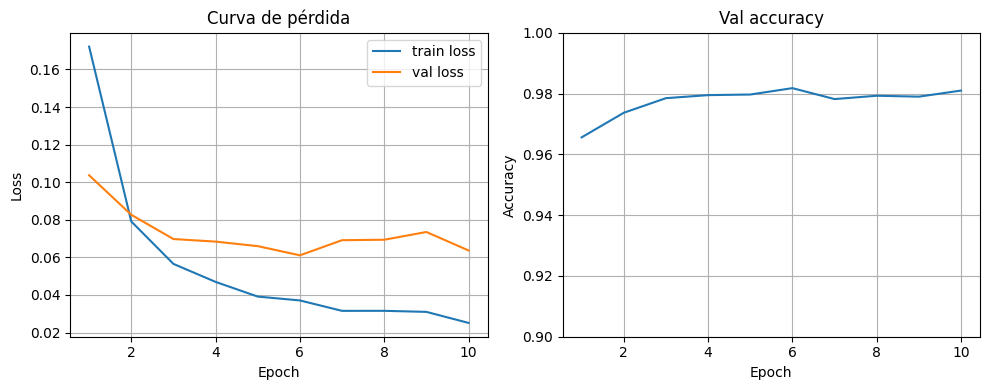

In [8]:
train_model([512,512,512], 0)

Epoch 00 | train 0.191 | val 0.105 | acc 0.9690
Epoch 01 | train 0.083 | val 0.080 | acc 0.9758
Epoch 02 | train 0.059 | val 0.075 | acc 0.9756
Epoch 03 | train 0.046 | val 0.081 | acc 0.9756
Epoch 04 | train 0.039 | val 0.064 | acc 0.9793
Epoch 05 | train 0.034 | val 0.069 | acc 0.9790
Epoch 06 | train 0.031 | val 0.068 | acc 0.9803
Epoch 07 | train 0.030 | val 0.065 | acc 0.9788
Epoch 08 | train 0.026 | val 0.069 | acc 0.9786
Epoch 09 | train 0.027 | val 0.065 | acc 0.9796


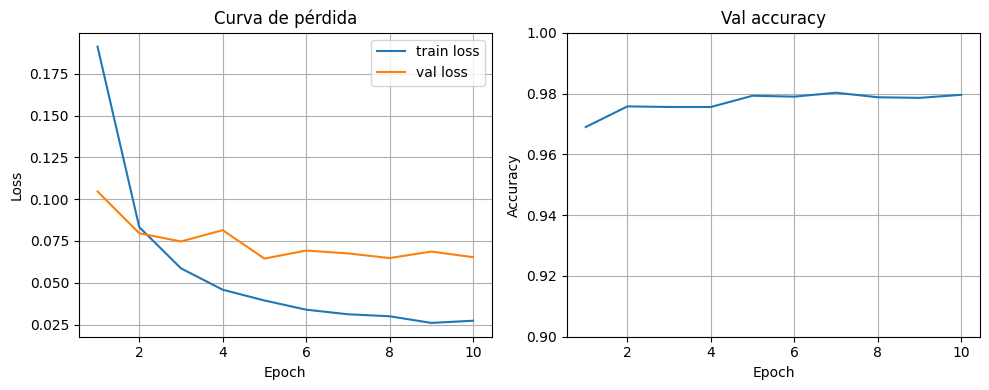

In [10]:
train_model([1024], 0)

Epoch 00 | train 0.294 | val 0.117 | acc 0.9642
Epoch 01 | train 0.152 | val 0.096 | acc 0.9708
Epoch 02 | train 0.122 | val 0.083 | acc 0.9754
Epoch 03 | train 0.108 | val 0.068 | acc 0.9797
Epoch 04 | train 0.096 | val 0.067 | acc 0.9807
Epoch 05 | train 0.087 | val 0.068 | acc 0.9797
Epoch 06 | train 0.085 | val 0.068 | acc 0.9795
Epoch 07 | train 0.079 | val 0.067 | acc 0.9794
Epoch 08 | train 0.079 | val 0.055 | acc 0.9834
Epoch 09 | train 0.071 | val 0.064 | acc 0.9809


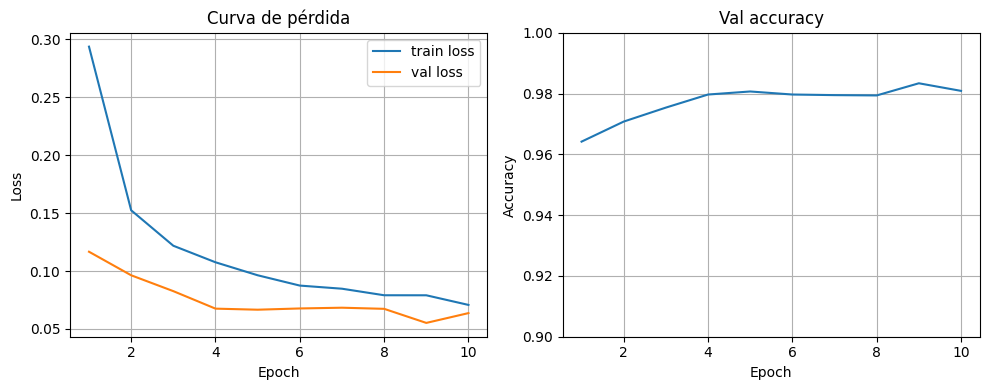

In [11]:
train_model([512,512,512,512,512],0.3)

Se llama a la función `train_model` en varias celdas con diferentes configuraciones para explorar el impacto de la arquitectura de la red (`hidden`) y la regularización (`p_drop`).

1.  **Celda con `train_model([512,512,512], 0)`**:
    *   `hidden=[512, 512, 512]`: Esta configuración define una red neuronal profunda con **tres capas ocultas**, cada una conteniendo **512 neuronas**. Una mayor cantidad de capas y neuronas aumenta la **capacidad** o **complejidad** del modelo, permitiéndole aprender patrones más intrincados en los datos.
    *   `p_drop=0`: La probabilidad de dropout se establece en 0. Esto significa que **no se aplica Dropout** durante el entrenamiento. El Dropout es una técnica de regularización para reducir el sobreajuste; al no usarlo, se evalúa el rendimiento de la red con su máxima capacidad de aprendizaje, pero con un mayor riesgo de sobreajuste si el modelo es demasiado complejo para la cantidad de datos.
    *   **Propósito**: Esta llamada prueba una red profunda con una capacidad considerable y **sin regularización Dropout**, sirviendo como base para entender el rendimiento máximo del modelo o como punto de comparación para evaluar el efecto del Dropout.

2.  **Celda con `train_model([1024], 0)`**:
    *   `hidden=[1024]`: Esta configuración define una red neuronal con **una sola capa oculta** que contiene **1024 neuronas**. Aunque tiene más neuronas en total que las tres capas de 512 de la primera configuración (1024 vs 3*512=1536), es una arquitectura **menos profunda** (menos capas ocultas). La profundidad de la red puede influir en su capacidad para aprender jerarquías de características.
    *   `p_drop=0`: Nuevamente, **no se aplica Dropout**.
    *   **Propósito**: Esta llamada compara el rendimiento de una red **menos profunda pero más ancha** en su única capa oculta, también **sin regularización Dropout**. Ayuda a entender la compensación entre profundidad y anchura de la red para esta tarea.

3.  **Celda con `train_model([512,512,512,512,512],0.3)`**:
    *   `hidden=[512, 512, 512, 512, 512]`: Esta configuración define una red con **cinco capas ocultas**, cada una con **512 neuronas**. Esta es la red **más profunda** probada, con la mayor cantidad de parámetros (5 * 512 = 2560 neuronas ocultas en total, además de las conexiones). Esto le da una **capacidad de aprendizaje muy alta**, potencialmente capaz de modelar relaciones complejas.
    *   `p_drop=0.3`: La probabilidad de dropout se establece en 0.3. Esto significa que durante el entrenamiento, el **30% de las neuronas** en las capas con Dropout (todas las capas ocultas excepto la de salida, según la definición de `DeepMLP`) se desactivarán aleatoriamente en cada iteración.
    *   **Propósito**: Esta llamada prueba una red con **alta capacidad (muy profunda)** y aplica **regularización Dropout** para mitigar el riesgo de sobreajuste asociado a modelos complejos. Permite evaluar si el Dropout ayuda a mejorar la generalización en una arquitectura muy profunda.

**Significado de variar estos parámetros**:

*   **`hidden` (Número y tamaño de capas ocultas)**: Variar este parámetro permite explorar cómo la **complejidad de la arquitectura** (su capacidad de modelado) afecta el rendimiento. Más capas o más neuronas por capa aumentan la capacidad, lo que es bueno para aprender patrones complejos, pero también aumenta el riesgo de **sobreajuste** (aprender el ruido en los datos de entrenamiento en lugar de los patrones generales).
*   **`p_drop` (Probabilidad de Dropout)**: Variar este parámetro permite controlar la cantidad de **regularización** aplicada. Un valor de `p_drop > 0` introduce aleatoriedad en el entrenamiento, forzando a la red a ser más robusta y menos dependiente de neuronas específicas. Esto es una técnica clave para **reducir el sobreajuste**, especialmente en modelos con alta capacidad. Probar diferentes valores permite encontrar un equilibrio entre la capacidad de aprendizaje y la generalización.